# Data preparation and feature engineering

### Description

In this notebook we perform data wrangling and feature engineering for 4 main groups of features representing the loans:
- **"client, account and card" features**: any information about the client, their type of card, age of their account, whether the accounts has multiple account holders...
- **"loan" features**: at a given date, what's the remaining principal, how many payments have been missed, etc.
- **"balance" features**: at a given date, information about the account balance during the past month, past quarter, past year...
- **"transaction" features**: at a given date, information about the volume, types and distribution of transactions during the past N months

### Switching to Spark if needed
The balance and transaction sections can be run in either python or pyspark depending on scalability needs, as these two data sources are most likely to be larger.
Most functions expect pandas dataframes as inputs except when specified. To run in a Spark environment:
- in the top right, click on the environment info icon > "Environment"
- select `Default Spark 2.4 & Python 3.6`: if this option is not there, contact your cluster administrator to install the Spark service
- select "Change Environment" when prompted
- once the Environment has restarted, the notebook will try to switch to the kernel available within that environment: select "Set kernel" when prompted
- **change the `RUN_IN_SPARK` high level parameter** in the next section


### Notes about the data and assumptions
- payments don't include interest
- all loan payments are always on the same given day in the month (in this dataset, on the 12th of the month)
- this notebook assumes that loan payments are made at most once per month

### List of features built in this notebook

In the following definitions:
- "Percent Change" between two quantities `x1` and `x2` is defined as `100*log(x1/x2)`
- "Logarithm" of a quantity `x` is defined as `x if x <0 else ln(1+x)` which lets us handle negative values while being continuous at `x=0`.

| **Feature Name**  | **Description** |
| :- |:-------------|
|prediction_date|Day on which the model would be run. Format: YYYY-MM-DD.|
|loan_id|Loan identifier. Foreign key to loan.csv.|
|default|Binary indicator of whether the loan will ever default.|
|date_of_default|If the loan does ever default, date of default.|
|date_of_first_payment|Date of the loan’s first payment.|
|date_of_last_payment|Date of the loan’s last payment.|
|default_12mth|Binary indicator, True if loan defaults within prediction_date and prediction_date + 365 days.|
| | |
|branch_id|Unique branch identifier for the account associated with the loan.|
|debit_card_type|Type of card for the account associated with the loan.|
|branch_city|City where the branch is located, for the account associated with the loan.|
|branch_state|State where the branch is located, for the account associated with the loan.|
|second_account_holder|'Y' if the account associated with the loan has a secondary account holder, 'N' otherwise.|
|email_service_primary|The email service (e.g. gmail, hotmail...) of the primary account holder, for the account associated with the loan.|
|sex_primary_is_female|'Y' if the primary account holder of the account associated with a loan identified as female, 'N' otherwise.|
|sex_secondary_is_female|'Y' if the secondary account holder of the account associated with a loan identified as female, 'N' otherwise or if there is no secondary account holder.|
|age_primary|Age (in years) of the primary account holder of the account associated with a loan.|
|age_secondary|Age (in years) of the secondary account holder of the account associated with a loan.|
|age_account|Number of years since creation of the account associated with the loan.|
|age_card|Number of years since the creation of the debit card of the account associated with the loan, 0 if no card is associated with the account.|
|  |  |
|loan_payment_amount|Amount that is being paid per month toward the loan.|
|loan_principal|Initial value of the loan when it was issued.|
|loan_duration|Initial number of months the loan is scheduled to be paid off in.|
|loan_purpose|Loan purpose category, as a string: *(car, debt_consolidation, etc.)*|
|loan_missing_payment|'Y' if payment for the loan was missing during the current month, 'N' otherwise.|
|loan_remaining_principal|Original value of the loan minus the amount that has ben paid off.|
|loan_remaining_principal_pct|Ratio of `loan_remaining_principal / loan_principal`.|
|loan_missing_payments_to_date|Number of times the account holder has missed a monthly loan payment.|
|loan_months_to_maturity|Number of months until the loan is scheduled to be paid off.|
|loan_age_in_days|Number of days since the loan was originally purchased.|
|  |  |
|balance_mean_current_month|Average balance on the account associated with the loan during most recent period (month).|
|balance_std_current_month|Standard Deviation of the balance on the account associated with the loan during most recent period (month).|
|balance_last_current_month|Most recent balance on the account associated with the loan during most recent period (month).|
|balance_std_current_quarter|Standard Deviation of the balance on the account associated with the loan during current rolling quarter.|
|balance_mean_current_year|Average balance on the account associated with the loan during current rolling year (most recent 12 months).|
|balance_std_current_year|Standard Deviation of the balance on the account associated with the loan during current rolling year (most recent 12 months).|
|balance_kurt_current_year|Kurtosis of the balance on the account associated with the loan during current rolling year (most recent 12 months).|
|balance_pct_change_qoq_consecutive|"Log Percent change" of the average balance on the account associated with the loan, between previous rolling quarter (t-6 months to t-3 months) and current rolling quarter (t-3 months to current month).|
|balance_pct_change_qoq_seasonal|"Log Percent change" of the average balance on the account associated with the loan, between the same quarter on the previous year (t-15 months to t-12 months) and current rolling quarter (t-3 months to current month).|
|balance_mean_current_month_log|"Logarithm" of `balance_mean_current_month`.|
|balance_last_current_month_log|"Logarithm" of `balance_last_current_month`.|
|balance_std_current_month_log|"Logarithm" of `balance_std_current_month`.|
|balance_ratio_std_to_mean_current_month|Ratio of `balance_std_current_month/balance_mean_current_month`.|
|balance_ratio_std_to_mean_current_year|Ratio of `balance_std_current_year/balance_mean_current_year`.|
|balance_ratio_std_to_mean_current_month_log|"Logarithm" of `balance_ratio_std_to_mean_current_month`.|
|balance_ratio_std_to_mean_current_year_log|"Logarithm" of `balance_ratio_std_to_mean_current_year`.|
|  |  |
|tx_credit_avg_amount|Average amount of credit transactions during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_debit_avg_amount|Average amount of debit transactions during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_credit_count|Average count of credit transactions per month during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_credit_pct|Average of "percentage of transactions that are credit transactions per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_credit_sum|Average of "sum of credit transaction amounts per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_debit_sum|Average of "sum of debit transaction amounts per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_cash_withdrawals_pct|Average of "percentage of transactions that are of type 'Cash Withdrawal' per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_credit_in_cash_pct|Average of "percentage of transactions that are of type  'Credit in Cash' per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_interest_credited_pct|Average of "percentage of transactions that are of type 'Interested Credited' per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_overdraft_fees_pct|Average of "percentage of transactions that are of type 'Overdraft Fee' per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|
|tx_monthly_avg_weekend_transactions_pct|Average of "percentage of transactions that are on weekend days per month" during last `OBSERVATION_WINDOW_LENGTH` months on the account associated with the loan.|


**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**

### High level parameters

In [1]:
OBSERVATION_WINDOW_LENGTH = 12 # number of previous months used to build transaction features
VALIDATION_SIZE = 0.5 # train/validation split for UNIQUE LOANS (see documentation): if equal to 0.3, 30% of the loans will be held out for validation of the model
RUN_IN_SPARK = False # indicate whether the transactional feature engineering portion should be run in Spark

### Check parameters

In [2]:
if not isinstance(OBSERVATION_WINDOW_LENGTH, int):
    raise Exception('Parameter OBSERVATION_WINDOW_LENGTH must be an integer.')
if not (VALIDATION_SIZE < 1 and VALIDATION_SIZE > 0):
    raise Exception('Parameter VALIDATION_SIZE must be between 0 (exclusive) and 1 (exclusive).')

if RUN_IN_SPARK and 'spark' not in locals():
    raise Exception('To run this notebook in Spark, change its environment to "Default Spark 2.4 & Python 3.6"')

# 0. Load libraries and define helper functions

In [3]:
# DATA WRANGLING
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # for the chart in section 3.2

from pandas.tseries.offsets import MonthEnd
import datetime

# VISUALIZATIONS
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split

# READING AND WRITING PROJECT ASSETS
import project_lib
project = project_lib.Project()

# SPARK
if RUN_IN_SPARK:
    from pyspark.sql import functions as F
    from pyspark.sql.window import Window

# 1. Load raw data

In [7]:
account = pd.read_csv(project.get_file('account.csv'), parse_dates=['creation_date'])
branch = pd.read_csv(project.get_file('branches.csv'))
card = pd.read_csv(project.get_file('card.csv'), parse_dates=['issued_date'])
client = pd.read_csv(project.get_file('client.csv'), parse_dates=['birth_date'])
disp = pd.read_csv(project.get_file('disp.csv'))
loan = pd.read_csv(project.get_file('loan.csv'), parse_dates=['loan_start_date'])

if not RUN_IN_SPARK:
    balance = pd.read_csv(project.get_file('balance.csv'))
    balance['transaction_period'] = balance['transaction_period'].apply(pd.Period)
    
    trans = pd.read_csv(project.get_file('trans.csv'), parse_dates=['transaction_date'])
else:
    balance = spark.read.option('inferSchema', 'true').csv(project.get_file('balance.csv'), header=True)
    trans = spark.read.option('inferSchema', 'true').csv(project.get_file('trans.csv'), header=True)

### Load labels

Here we are reading labels that were generated by sprint 0, which has some default parameters regarding the definition of default (90 day delinquency), the length of the prediction window (12 months) and how often training points are generated (every month).

In [8]:
labels = pd.read_csv(project.get_file('labels.csv'),
                     parse_dates=['prediction_date', 'date_of_default', 'date_of_first_payment', 'date_of_last_payment'])

# 2. Build all feature sets

## 2.1 Client, account and card information

Each loan is linked to exactly one account. Each account can have multiple co-owners. The dataset `disp` indicates which clients have access to which accounts.

### Non time-dependent features

In [9]:
def build_client_features_non_time_dependent(client_data, loan_data, disp_data, account_data, card_data, branch_data):
    # start with client information
    client_features = client_data.copy(deep=False) # non-deep copy to avoid actually copying the df in memory

    # map to accounts:
    client_features = pd.merge(client_features, disp_data, on='client_id')
    client_features = pd.merge(client_features, account_data, on='account_id')

    # map to cards (warning: not all clients have cards! this must be a left join):
    client_features = pd.merge(client_features, card_data, on='disp_id', how='left')
    client_features = client_features.drop(columns=['disp_id'])

    # map to account locations:
    client_features = pd.merge(client_features, branch_data, on='branch_id')

    # map to loans:
    client_features = pd.merge(client_features, loan_data, on='account_id')
    client_features = client_features.drop(columns=['account_id'])

    # do a self join to merge owners and users into one row:
    owner = client_features[client_features['type'] == 'Owner'].drop(['type', 'client_id'], axis=1)
    user = client_features.loc[client_features['type'] == 'User', ['sex', 'birth_date', 'loan_id']]
    client_features = pd.merge(owner, user, how='left', on='loan_id',
                               suffixes=['_primary', '_secondary'], indicator=True)

    # add secondary account indicator based on results of merging
    client_features['second_account_holder'] = (client_features['_merge'] == 'both')
    client_features = client_features.drop(columns=['_merge'])

    # add features
    client_features['email_service_primary'] = (client_features['email'].str.split('@', expand=True).iloc[:, 1] # e.g. extract "gmail.com"
                                                                        .str.split('.', expand=True).iloc[:, 0]) # e.g. extract "gmail"
    client_features = client_features.drop(columns=['email'])

    # encode binaries
    client_features['sex_primary_is_female'] = (client_features['sex_primary'] == 'Female')
    client_features['sex_secondary_is_female'] = (client_features['sex_secondary'] == 'Female')
    client_features.drop(['sex_primary', 'sex_secondary'], axis=1, inplace=True)
    
    # fill some NaNs
    client_features['debit_card_type'] = client_features['debit_card_type'].fillna('No Card')

    return client_features

In [10]:
client_features_static = build_client_features_non_time_dependent(client[['client_id', 'sex', 'birth_date', 'email']],
                                                                  loan[['loan_id','account_id']],
                                                                  disp[['disp_id', 'client_id', 'account_id', 'type']],
                                                                  account[['account_id', 'creation_date', 'branch_id']],
                                                                  card[['disp_id', 'debit_card_type', 'issued_date']].rename(columns={'issued_date': 'card_issued_date'}),
                                                                  branch[['branch_id', 'branch_city', 'branch_state']])
display(client_features_static.head())
client_features_static.shape

birth_date_primary creation_date  branch_id debit_card_type  \
0         1965-02-04    2013-02-26  B00000002         No Card   
1         1960-01-30    2017-08-08  B00000002         No Card   
2         1965-07-03    2016-05-11  B00000002  VISA Signature   
3         1964-10-25    2017-02-23  B00000002  VISA Signature   
4         1982-12-28    2013-03-08  B00000002         No Card   

  card_issued_date branch_city branch_state    loan_id birth_date_secondary  \
0              NaT    New York           NY  L00004959           1960-10-09   
1              NaT    New York           NY  L00004968                  NaT   
2       2017-12-06    New York           NY  L00004996           1958-09-10   
3       2017-12-05    New York           NY  L00005015                  NaT   
4              NaT    New York           NY  L00005519           1981-03-26   

   second_account_holder email_service_primary  sex_primary_is_female  \
0                   True                 gmail                  False   
1                  False                 gmail                   True   
2                   True                 gmail                   True   
3                  False                 gmail                   True   
4                   True                 gmail                   True   

   sex_secondary_is_female  
0                     True  
1                    False  
2                    False  
3                    False  
4                    False

(682, 13)

### Time-dependent features

Now that we have prepared all the client-level information that doesn't change with time, we merge with the label dates in order to incorporate client characteristics that change with time (e.g. age). In other terms, we will switch from having one row per loan to having one row per (loan, prediction date) combination:

In [11]:
def build_client_features_time_dependent(client_features, prediction_dates):
    """
    Builds time-dependent features for each (loan_id, prediction_date) combination.
    Args:
        - client_features: a dataframe of non time-dependent features
        - prediction_dates: a dataframe containing (loan_id, prediction_date) combinations
    """
    def helper_age_in_years(data, col_name, prediction_date_col="prediction_date"):
        # Note age can't be an int because we wouldn't be able to support NaNs (which are floats in python)
        age = data[prediction_date_col] - data[col_name] # this is a timedelta
        age = (age.dt.days/365).round(0)
        return age
    
    client_features = client_features.copy(deep=False)
    client_features = pd.merge(prediction_dates, client_features, how='left', on='loan_id')
    
    client_features['age_primary'] = helper_age_in_years(client_features, 'birth_date_primary')
    client_features['age_secondary'] = helper_age_in_years(client_features, 'birth_date_secondary')

    client_features['age_account'] = helper_age_in_years(client_features, 'creation_date')
    client_features['age_card'] = helper_age_in_years(client_features, 'card_issued_date')

    client_features = client_features.drop(columns=['birth_date_primary', 'birth_date_secondary', 'creation_date', 'card_issued_date'])
    
    # fill some NaNs
    client_features['age_card'] = client_features['age_card'].fillna(0)
    client_features.loc[client_features['age_secondary'].isna(), 'age_secondary'] = client_features.loc[client_features['age_secondary'].isna(), 'age_primary']
    
    return client_features

In [12]:
client_features = build_client_features_time_dependent(client_features_static, labels[['loan_id', 'prediction_date']])
display(client_features.head())
client_features.shape

loan_id prediction_date  branch_id debit_card_type branch_city  \
0  L00004959      2014-01-31  B00000002         No Card    New York   
1  L00004959      2014-02-28  B00000002         No Card    New York   
2  L00004959      2014-03-31  B00000002         No Card    New York   
3  L00004959      2014-04-30  B00000002         No Card    New York   
4  L00004959      2014-05-31  B00000002         No Card    New York   

  branch_state  second_account_holder email_service_primary  \
0           NY                   True                 gmail   
1           NY                   True                 gmail   
2           NY                   True                 gmail   
3           NY                   True                 gmail   
4           NY                   True                 gmail   

   sex_primary_is_female  sex_secondary_is_female  age_primary  age_secondary  \
0                  False                     True         49.0           53.0   
1                  False                     True         49.0           53.0   
2                  False                     True         49.0           54.0   
3                  False                     True         49.0           54.0   
4                  False                     True         49.0           54.0   

   age_account  age_card  
0          1.0       0.0  
1          1.0       0.0  
2          1.0       0.0  
3          1.0       0.0  
4          1.0       0.0

(8469, 14)

## 2.2 Loan information

In [13]:
def build_loan_features(loan_payments_data, loan_data, prediction_dates):
    """
    Builds time-dependent loan related features for each (loan_id, prediction_date) combination.
    Args:
        - loan_payments_data: a dataframe containing rows representing payments for loans (`loan_id`) on given dates (`payment_date`)
        - loan_data: a dataframe containing information about loans: start date, end date, latest payment data available, amount...
        - prediction_dates: a dataframe containing (loan_id, prediction_date) combinations
    Assumptions:
        - payments in `loan_payments_data` are made at most once a month
    """
    loan_features = loan_data.copy(deep=False) # non-deep copy to avoid actually copying the df in memory
    loan_features = pd.merge(loan_payments_data, loan_features, on='account_id')
    loan_features.drop('account_id', axis=1, inplace=True)

    # Switch dates to end of month to merge with prediction_dates:
    loan_features['prediction_date'] = loan_features['payment_date'] + MonthEnd(1)
    loan_features = pd.merge(prediction_dates, loan_features, how='left', on=['loan_id', 'prediction_date'], indicator=True)

    # For months of missing payments, fill with latest information available on that date (from previous payment) except for payments:
    to_fill = ['payment_date', 'loan_principal', 'loan_duration', 'loan_start_date', 'loan_purpose']
    loan_features[to_fill] = loan_features.groupby('loan_id')[to_fill].fillna(method='ffill')
    loan_features['loan_payment_amount'].fillna(0, inplace=True)
    loan_features['loan_missing_payment'] = loan_features['_merge'] == 'left_only'
    loan_features.drop('_merge', axis=1, inplace=True)

    loan_features.sort_values(['loan_id', 'prediction_date'], inplace=True)

    # Calculate Loan Balance
    loan_features['loan_remaining_principal'] = loan_features['loan_principal'] - (loan_features.groupby('loan_id')['loan_payment_amount'].cumsum())
    # This is the inverse of the `loan_payment_pressure` feature we used to have to make it a bit more explainable (and avoid inf issues):
    loan_features['loan_remaining_principal_pct'] = (loan_features['loan_remaining_principal']/loan_features["loan_principal"]).round(2)

    loan_features['loan_missing_payments_to_date'] = loan_features.groupby('loan_id')['loan_missing_payment'].cumsum()

    loan_features['payment_made'] = 1 - loan_features['loan_missing_payment']  # temporary
    loan_features['loan_months_to_maturity'] = loan_features['loan_duration'] - loan_features.groupby('loan_id')['payment_made'].cumsum()
    loan_features['loan_age_in_days'] = (loan_features['prediction_date'] - loan_features['loan_start_date']).dt.days
    loan_features.drop(['loan_start_date', 'payment_made', 'payment_date'], axis=1, inplace=True)
    return loan_features

In [14]:
if not RUN_IN_SPARK:
    loan_payments = trans.loc[trans['tx_type_3'] == "Loan Payment", ['account_id', 'transaction_date', 'amount']]
else:
    loan_payments = trans.where(trans['tx_type_3'] == 'Loan Payment').select(['account_id', 'transaction_date', 'amount']).toPandas()
loan_payments.rename(columns={'transaction_date': 'payment_date', 'amount': 'loan_payment_amount'}, inplace=True)

loan_features = build_loan_features(loan_payments, loan.drop(['loan_payments'], axis=1), labels[['loan_id', 'prediction_date']])
display(loan_features.head())
loan_features.shape

loan_id prediction_date  loan_payment_amount  loan_principal  \
0  L00004959      2014-01-31               3372.7         80952.0   
1  L00004959      2014-02-28               3372.7         80952.0   
2  L00004959      2014-03-31               3372.7         80952.0   
3  L00004959      2014-04-30               3372.7         80952.0   
4  L00004959      2014-05-31               3372.7         80952.0   

   loan_duration loan_purpose  loan_missing_payment  loan_remaining_principal  \
0           24.0         home                 False                   77579.3   
1           24.0         home                 False                   74206.6   
2           24.0         home                 False                   70833.9   
3           24.0         home                 False                   67461.2   
4           24.0         home                 False                   64088.5   

   loan_remaining_principal_pct  loan_missing_payments_to_date  \
0                          0.96                            0.0   
1                          0.92                            0.0   
2                          0.88                            0.0   
3                          0.83                            0.0   
4                          0.79                            0.0   

   loan_months_to_maturity  loan_age_in_days  
0                     23.0                26  
1                     22.0                54  
2                     21.0                85  
3                     20.0               115  
4                     19.0               146

(8469, 12)

## 2.3 Balance information

In this section, we first build balance aggregates for every time period represented in the balance table (in our sample dataset, every month).

We then merge with labels to only keep aggregates that map to a point in time where we want to train the model or make a prediction: e.g. if the labels were generated at a 3 month frequency, we'll build monthly balance aggregates, but then only keep aggregates at the same 3 month frequency through the join with labels.

In [15]:
def build_balance_features(balance_data, loan_to_account_mapping, prediction_dates, min_periods=0):
    """
    Builds time-dependent balance related features for each (loan_id, prediction_date) combination.
    Args:
        - balance_data: a dataframe containing rows representing balances of accounts indexed by `account_id`
                        during given periods `transaction_period` (of type pd.Period)
        - loan_to_account_mapping: a dataframe containing mapping between `loan_id` and `account_id`
        - prediction_dates: a dataframe containing (loan_id, prediction_date) combinations
        - min_periods: the minimal number of observation needed in a time period (e.g. a quarter)
                       to compute an aggregate for that period. E.g. min_periods=2, an account with balance info
                       for only one month during a quarter will have any quarterly aggregates set to NaN.
    Assumptions:
        - balance_data contains pre-aggregated balance data: one row per account per period.
        - there are no missing periods: if the account is active we always have access to its balance
    """
    def helper_log_pct_change(data, col_1, col_2, fill_value=0):
        """
        We use 100*log(x1/x2) as a way to measure change between two quantities.
        By default we fill NaNs with 0 i.e. a change from no quantity to a quantity is just encoded as no change."""
        return (100*np.log(data[col_1]/data[col_2])).fillna(fill_value)
    
    def helper_log(x):
        """In order to take the log of potentially negative variables, we use: log(1 + x) if x >= 0, else x"""
        return np.where(x < 0, x, np.log(1 + x))
    
    # merge with loans
    balance_features = pd.merge(balance_data, loan_to_account_mapping, how='inner')
    balance_features['prediction_date'] = balance_features['transaction_period'].dt.to_timestamp(how='end').dt.floor('D')
    balance_features.rename(columns={'balance_mean': 'balance_mean_current_month',
                                     'balance_std': 'balance_std_current_month',
                                     'balance_last': 'balance_last_current_month'},
                            inplace=True)
    balance_features.drop(['account_id', 'transaction_period'], axis=1, inplace=True)

    # make sure that this table is sorted -> important for all the next steps involving rolling and shifting
    balance_features.sort_values(['loan_id', 'prediction_date'], inplace=True)

    current_rolling_quarter = (balance_features.set_index(['loan_id', 'prediction_date'])
                                               .groupby('loan_id')
                                               .rolling(3, min_periods=min_periods)['balance_mean_current_month']
                                               .agg(['mean', 'std'])
                                               .droplevel(0)
                                               .reset_index()
                                               .rename(columns={'mean': 'balance_mean_current_quarter',
                                                                'std': 'balance_std_current_quarter'}))

    previous_rolling_quarter = (balance_features.set_index(['loan_id', 'prediction_date'])
                                                .groupby('loan_id')
                                                .shift(3).rolling(3, min_periods=min_periods)['balance_mean_current_month']
                                                .mean()
                                                .reset_index()
                                                .rename(columns={'balance_mean_current_month': 'balance_mean_previous_quarter'}))

    previous_year_rolling_quarter = (balance_features.set_index(['loan_id', 'prediction_date'])
                                                     .groupby('loan_id')
                                                     .shift(12).rolling(3, min_periods=min_periods)['balance_mean_current_month']
                                                     .mean()
                                                     .reset_index()
                                                     .rename(columns={'balance_mean_current_month': 'balance_mean_previous_year_same_quarter'}))

    current_year = (balance_features.set_index(['loan_id', 'prediction_date'])
                                    .groupby('loan_id')
                                    .rolling(12, min_periods=min_periods)['balance_mean_current_month']
                                    .agg(['mean', 'std', 'kurt'])
                                    .droplevel(0)
                                    .reset_index()
                                    .rename(columns={'mean': 'balance_mean_current_year',
                                                     'std': 'balance_std_current_year',
                                                     'kurt': 'balance_kurt_current_year'}))

    balance_features = pd.merge(balance_features, current_rolling_quarter, on=['loan_id', 'prediction_date'])
    balance_features = pd.merge(balance_features, previous_rolling_quarter, on=['loan_id', 'prediction_date'])
    balance_features = pd.merge(balance_features, previous_year_rolling_quarter, on=['loan_id', 'prediction_date'])
    balance_features = pd.merge(balance_features, current_year, on=['loan_id', 'prediction_date'])

    balance_features['balance_pct_change_qoq_consecutive'] = helper_log_pct_change(balance_features,
                                                                                   'balance_mean_current_quarter',
                                                                                   'balance_mean_previous_quarter')

    balance_features['balance_pct_change_qoq_seasonal'] = helper_log_pct_change(balance_features,
                                                                                'balance_mean_current_quarter',
                                                                                'balance_mean_previous_year_same_quarter')

    balance_features.drop(columns=['balance_mean_current_quarter', 'balance_mean_previous_quarter', 'balance_mean_previous_year_same_quarter'],
                          inplace=True)
    
    # fill NaNs    
    # by definition, a missing kurtosis can be filled with 3
    balance_features['balance_kurt_current_year'] = balance_features['balance_kurt_current_year'].fillna(3)
    # by default, pandas returns a less biased estimator of the stddev by normalizing by N-1 (N=nb of sample) i.e. degrees of freedom
    # for sample size 1, we fill with 0 which is what numpy would return by default:
    balance_features[['balance_std_current_quarter']] = balance_features[['balance_std_current_quarter']].fillna(0)
    balance_features['balance_std_current_month'] = balance_features['balance_std_current_month'].fillna(0)
    balance_features[['balance_std_current_year']] = balance_features[['balance_std_current_year']].fillna(0)
    
    # Non linear transformations
    balance_features['balance_mean_current_month_log'] = helper_log(balance_features['balance_mean_current_month'])
    balance_features['balance_last_current_month_log'] = helper_log(balance_features['balance_last_current_month'])
    balance_features['balance_std_current_month_log'] = helper_log(balance_features['balance_std_current_month'])

    # Interactions
    balance_features['balance_ratio_std_to_mean_current_month'] =  balance_features['balance_std_current_month']/balance_features['balance_mean_current_month']
    balance_features['balance_ratio_std_to_mean_current_year'] =  balance_features['balance_std_current_year']/balance_features['balance_mean_current_year']

    # Non linear transformations of the interactions
    balance_features['balance_ratio_std_to_mean_current_month_log'] = helper_log(balance_features['balance_ratio_std_to_mean_current_month'])
    balance_features['balance_ratio_std_to_mean_current_year_log'] = helper_log(balance_features['balance_ratio_std_to_mean_current_year'])
    
    # Filter months to only match selected prediction dates
    balance_features = pd.merge(prediction_dates, balance_features, on=['loan_id', 'prediction_date'], how='left')
    
    return balance_features

In [16]:
def build_balance_features_spark(balance_data, loan_to_account_mapping, prediction_dates, min_periods=0):
    """
    Builds time-dependent balance related features for each (loan_id, prediction_date) combination.
    Args:
        - balance_data: a Spark dataframe containing rows representing balances of accounts indexed by `account_id`
                        during given periods `transaction_period` (of type pd.Period)
        - loan_to_account_mapping: a dataframe containing mapping between `loan_id` and `account_id`
        - prediction_dates: a dataframe containing (loan_id, prediction_date) combinations
        - min_periods: the minimal number of observation needed in a time period (e.g. a quarter)
                       to compute an aggregate for that period. E.g. min_periods=2, an account with balance info
                       for only one month during a quarter will have any quarterly aggregates set to NaN.
    Assumptions:
        - balance_data contains pre-aggregated balance data: one row per account per period.
        - there are no missing periods: if the account is active we always have access to its balance
        
    Note:
        - This function replicates exactly `build_balance_features` but with balance data as a Spark dataframe
        - Because of the way kurtosis is calculated in pandas (unbiased estimator), that column might be different
          in this spark implementation.
    """
    def helper_log_pct_change(data, new_col_name, col_1, col_2, fill_value=0):
        """
        We use 100*log(x1/x2) as a way to measure change between two quantities.
        By default we fill NaNs with 0 i.e. a change from no quantity to a quantity is just encoded as no change."""
        return data.withColumn(new_col_name, 100*F.log(F.col(col_1)/F.col(col_2))).fillna(fill_value, subset=new_col_name)
    
    def helper_log(data, new_col_name, col):
        """In order to take the log of potentially negative variables, we use: log(1 + x) if x >= 0, else x"""
        return data.withColumn(new_col_name, F.when(F.col(col) < 0, F.col(col)).otherwise(F.log(1 + F.col(col))))

    balance_features = balance_data.join(spark.createDataFrame(loan_to_account_mapping), on='account_id')
    balance_features = balance_features.withColumn('prediction_date', F.last_day(F.to_date(F.col('transaction_period'))))
    balance_features = (balance_features.withColumnRenamed('balance_mean', 'balance_mean_current_month')
                                        .withColumnRenamed('balance_std', 'balance_std_current_month')
                                        .withColumnRenamed('balance_last', 'balance_last_current_month')
                                        .drop('account_id', 'transaction_period')
                       )

    w = (Window.partitionBy('loan_id').orderBy(F.col('prediction_date')).rowsBetween(-2, 0))
    balance_features = (balance_features.withColumn('balance_mean_current_quarter', F.avg("balance_mean_current_month").over(w))
                                        .withColumn('balance_std_current_quarter', F.stddev("balance_mean_current_month").over(w)))


    w = (Window.partitionBy('loan_id').orderBy(F.col('prediction_date')).rowsBetween(-5, -3))
    balance_features = (balance_features.withColumn('balance_mean_previous_quarter', F.avg("balance_mean_current_month").over(w)))

    w = (Window.partitionBy('loan_id').orderBy(F.col('prediction_date')).rowsBetween(-14, -12))
    balance_features = (balance_features.withColumn('balance_mean_previous_year_same_quarter', F.avg("balance_mean_current_month").over(w)))

    w = (Window.partitionBy('loan_id').orderBy(F.col('prediction_date')).rowsBetween(-11, 0))
    balance_features = (balance_features.withColumn('balance_mean_current_year', F.avg("balance_mean_current_month").over(w))
                                        .withColumn('balance_std_current_year', F.stddev("balance_mean_current_month").over(w))
                                        .withColumn('balance_kurt_current_year', F.kurtosis("balance_mean_current_month").over(w))
                       )

    balance_features = helper_log_pct_change(balance_features, 'balance_pct_change_qoq_consecutive',
                                             'balance_mean_current_quarter', 'balance_mean_previous_quarter')

    balance_features = helper_log_pct_change(balance_features, 'balance_pct_change_qoq_seasonal',
                                             'balance_mean_current_quarter', 'balance_mean_previous_year_same_quarter')

    balance_features = balance_features.drop('balance_mean_current_quarter', 'balance_mean_previous_quarter', 'balance_mean_previous_year_same_quarter')


    # fill NaNs    
    balance_features = balance_features.fillna({'balance_kurt_current_year': 3, # by definition, a missing kurtosis can be filled with 3
                                                'balance_std_current_quarter': 0,
                                                'balance_std_current_month': 0,
                                                'balance_std_current_year': 0})

    # Non linear transformations
    balance_features = helper_log(balance_features, 'balance_mean_current_month_log', 'balance_mean_current_month')
    balance_features = helper_log(balance_features, 'balance_last_current_month_log', 'balance_last_current_month')
    balance_features = helper_log(balance_features, 'balance_std_current_month_log', 'balance_std_current_month')

    # Interactions
    balance_features = (balance_features.withColumn('balance_ratio_std_to_mean_current_month', F.col('balance_std_current_month')/F.col('balance_mean_current_month'))
                                        .withColumn('balance_ratio_std_to_mean_current_year',  F.col('balance_std_current_year')/F.col('balance_mean_current_year')))

    # Non linear transformations of the interactions
    balance_features = helper_log(balance_features, 'balance_ratio_std_to_mean_current_month_log', 'balance_ratio_std_to_mean_current_month')
    balance_features = helper_log(balance_features, 'balance_ratio_std_to_mean_current_year_log', 'balance_ratio_std_to_mean_current_year')

    # Filter months to only match selected prediction dates
    balance_features = spark.createDataFrame(prediction_dates).join(balance_features, on=['loan_id', 'prediction_date'], how='left')
    return balance_features

In [17]:
if not RUN_IN_SPARK:
    balance_features = build_balance_features(balance, loan[['loan_id', 'account_id']], labels[['loan_id', 'prediction_date']])
    display(balance_features.head())
    balance_features.shape
else:
    balance_features = build_balance_features_spark(balance, loan[['loan_id', 'account_id']], labels[['loan_id', 'prediction_date']])
    balance_features = balance_features.toPandas()
    display(balance_features.head())
    balance_features.shape

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log


loan_id prediction_date  balance_mean_current_month  \
0  L00004959      2014-01-31                     28187.7   
1  L00004959      2014-02-28                     25671.2   
2  L00004959      2014-03-31                     31169.1   
3  L00004959      2014-04-30                     34638.0   
4  L00004959      2014-05-31                     29705.0   

   balance_std_current_month  balance_last_current_month  \
0                     8210.0                     20053.3   
1                     6881.7                     26244.2   
2                     6859.2                     31056.1   
3                     7052.2                     33188.8   
4                    10272.3                     20308.0   

   balance_std_current_quarter  balance_mean_current_year  \
0                  2066.370451               31368.108333   
1                  2077.388945               33415.708333   
2                  2752.224029               34029.200000   
3                  4521.498164               33749.983333   
4                  2533.487222               32646.583333   

   balance_std_current_year  balance_kurt_current_year  \
0              13068.712283                   1.946328   
1               9267.185713                  -0.034073   
2               8805.449726                   0.193329   
3               8721.205293                   0.553375   
4               8278.353958                   2.477600   

   balance_pct_change_qoq_consecutive  balance_pct_change_qoq_seasonal  \
0                            8.934926                         0.000000   
1                            0.037544                       323.273570   
2                           -0.929127                        82.235859   
3                            1.331322                        37.462240   
4                           13.259478                        -9.224342   

   balance_mean_current_month_log  balance_last_current_month_log  \
0                       10.246676                        9.906199   
1                       10.153164                       10.175238   
2                       10.347215                       10.343583   
3                       10.452735                       10.409998   
4                       10.299104                        9.918819   

   balance_std_current_month_log  balance_ratio_std_to_mean_current_month  \
0                       9.013230                                 0.291262   
1                       8.836766                                 0.268071   
2                       8.833492                                 0.220064   
3                       8.861237                                 0.203597   
4                       9.237304                                 0.345810   

   balance_ratio_std_to_mean_current_year  \
0                                0.416624   
1                                0.277330   
2                                0.258762   
3                                0.258406   
4                                0.253575   

   balance_ratio_std_to_mean_current_month_log  \
0                                     0.255620   
1                                     0.237497   
2                                     0.198903   
3                                     0.185315   
4                                     0.296996   

   balance_ratio_std_to_mean_current_year_log  
0                                    0.348277  
1                                    0.244772  
2                                    0.230128  
3                                    0.229846  
4                                    0.225999

## 2.4 Transaction information

In this section we follow the same strategy as for balance features: we build transaction features for all months represented in the data, and then merge with the prediction dates represented in the labels to only keep features for the right dates.

In [18]:
def build_transaction_features(transaction_data, loan_to_account_mapping, prediction_dates, n_months=12, min_peridods=0):
    """
    Builds time-dependent transaction related features for each (loan_id, prediction_date) combination.
    Args:
        - transaction_data: a dataframe containing transactions on accounts, with three types of categories
                            `tx_type_1`, `tx_type_2`, `tx_type_3`
        - loan_to_account_mapping: a dataframe containing mapping between `loan_id` and `account_id`
        - prediction_dates: a dataframe containing (loan_id, prediction_date) combinations
        - n_months: number of months to use to build a rolling 'observation window' to build features on.
        - min_periods: the minimal number of observation needed in a time period (e.g. a quarter)
                       to compute an aggregate for that period. E.g. min_periods=2, an account with transactions
                       for only one month during a quarter will have any quarterly aggregates set to NaN.
    """
    def helper_agg_per_period(transaction_data, columns=['tx_type_1'], aggfunc='sum'):
        result = pd.pivot_table(transaction_data,
                                values='amount',
                                index=['loan_id', 'transaction_period'],
                                columns=columns,
                                aggfunc=aggfunc,
                                fill_value=0)
        # cleanup index name and column names:
        result.rename_axis(None, axis=1, inplace=True)
        result.columns = result.columns.map(lambda c: f"{aggfunc}_{c.lower().replace(' ', '_').replace('.', '')}")
        return result
                                        
    transactions = pd.merge(transaction_data, loan_to_account_mapping)
    transactions.drop(['account_id'], axis=1, inplace=True)

    transactions['transaction_period'] = transactions['transaction_date'].dt.to_period('m')
    transactions['tx_type_3'].replace(' ', 'other', inplace=True)
    
    # get monthly aggregates
    count_tx_type_1 = helper_agg_per_period(transactions, columns=['tx_type_1'], aggfunc='count')
    sum_tx_type_1 = helper_agg_per_period(transactions, columns=['tx_type_1'])
    sum_tx_type_2 = helper_agg_per_period(transactions, columns=['tx_type_2'])
    sum_tx_type_3 = helper_agg_per_period(transactions, columns=['tx_type_3'])

    pct_tx_type_1 = sum_tx_type_1.div(sum_tx_type_1.sum(axis=1), axis=0)
    pct_tx_type_2 = sum_tx_type_2.div(sum_tx_type_2.sum(axis=1), axis=0)
    pct_tx_type_3 = sum_tx_type_3.div(sum_tx_type_3.sum(axis=1), axis=0)
    for df in [pct_tx_type_1, pct_tx_type_2, pct_tx_type_3]:
        df.columns = [c.replace('sum', 'pct') for c in df]

    pct_weekend_transactions = (transactions.assign(is_weekend=transactions['transaction_date'].dt.weekday_name.isin(['Saturday', 'Sunday']))
                                            .groupby(['loan_id', 'transaction_period'])
                                            .agg({'is_weekend': 'mean'}))

    # join back all types of monthly aggregates together
    monthly_aggregates = count_tx_type_1
    monthly_aggregates = pd.merge(monthly_aggregates, sum_tx_type_1, left_index=True, right_index=True, how='left')
    monthly_aggregates = pd.merge(monthly_aggregates, sum_tx_type_3, left_index=True, right_index=True, how='left')
    monthly_aggregates = pd.merge(monthly_aggregates, pct_tx_type_1, left_index=True, right_index=True, how='left')
    monthly_aggregates = pd.merge(monthly_aggregates, pct_tx_type_2, left_index=True, right_index=True, how='left')
    monthly_aggregates = pd.merge(monthly_aggregates, pct_tx_type_3, left_index=True, right_index=True, how='left')
    monthly_aggregates = pd.merge(monthly_aggregates, pct_weekend_transactions, left_index=True, right_index=True, how='left')

    # summarize monthly aggregates in rolling window
    # monthly_aggregates.sort_values(['loan_id', 'transaction_period'], inplace=True)
    monthly_aggregates.sort_index(inplace=True)
    rolling_year_aggregates = (monthly_aggregates.groupby('loan_id')
                                                 .rolling(n_months, min_periods=0)
                                                 .agg({'sum_credit': ['sum', 'mean'],
                                                       'sum_debit': ['sum', 'mean'],
                                                       'count_debit': ['sum', 'mean'],
                                                       'count_credit': ['sum', 'mean'],
                                                       'pct_cash_withdrawal': 'mean',
                                                       'pct_credit_in_cash': 'mean',
                                                       'pct_interest_credited': 'mean',
                                                       'pct_overdraft_fee': 'mean',
                                                       'sum_overdraft_fee': 'sum',
                                                       'pct_credit': 'mean',
                                                       'is_weekend': 'mean'
                                                      })
                                                 .droplevel(0))

    rolling_year_aggregates.columns = rolling_year_aggregates.columns.map('_'.join)
    
    # build final features dataframe
    transaction_features = pd.DataFrame()

    transaction_features['tx_credit_avg_amount'] = (rolling_year_aggregates['sum_credit_sum'] / rolling_year_aggregates['count_credit_sum']).fillna(0)
    transaction_features['tx_debit_avg_amount'] = (rolling_year_aggregates['sum_debit_sum'] / rolling_year_aggregates['count_debit_sum']).fillna(0)

    transaction_features['tx_monthly_avg_credit_count'] = rolling_year_aggregates['count_credit_mean']
    transaction_features['tx_monthly_avg_credit_pct'] = rolling_year_aggregates['pct_credit_mean']

    transaction_features['tx_monthly_avg_credit_sum'] = rolling_year_aggregates['sum_credit_mean']
    transaction_features['tx_monthly_avg_debit_sum'] = rolling_year_aggregates['sum_debit_mean']

    transaction_features['tx_monthly_avg_cash_withdrawals_pct'] = rolling_year_aggregates['pct_cash_withdrawal_mean']
    transaction_features['tx_monthly_avg_credit_in_cash_pct'] = rolling_year_aggregates['pct_credit_in_cash_mean']
    transaction_features['tx_monthly_avg_interest_credited_pct'] = rolling_year_aggregates['pct_interest_credited_mean']
    transaction_features['tx_monthly_avg_overdraft_fees_pct'] = rolling_year_aggregates['pct_overdraft_fee_mean']

    transaction_features['tx_monthly_avg_weekend_transactions_pct'] = rolling_year_aggregates['is_weekend_mean']

    transaction_features.reset_index(inplace=True)

    transaction_features['prediction_date'] = transaction_features['transaction_period'].dt.to_timestamp().dt.date + MonthEnd(1)
    transaction_features.drop(columns='transaction_period', inplace=True)
    
    # Filter months to only match selected prediction dates
    transaction_features = pd.merge(prediction_dates, transaction_features, on=['loan_id', 'prediction_date'], how='left')
    
    return transaction_features

In [19]:
def build_transaction_features_spark(transaction_data, loan_to_account_mapping, prediction_dates, n_months=12, min_peridods=0):
    """
    Builds time-dependent transaction related features for each (loan_id, prediction_date) combination.
    Args:
        - transaction_data: a Spark dataframe containing transactions on accounts, with three types of categories
                            `tx_type_1`, `tx_type_2`, `tx_type_3`
        - loan_to_account_mapping: a dataframe containing mapping between `loan_id` and `account_id`
        - prediction_dates: a dataframe containing (loan_id, prediction_date) combinations
        - n_months: number of months to use to build a rolling 'observation window' to build features on.
        - min_periods: the minimal number of observation needed in a time period (e.g. a quarter)
                       to compute an aggregate for that period. E.g. min_periods=2, an account with transactions
                       for only one month during a quarter will have any quarterly aggregates set to NaN.
    Note:
        - This function replicates exactly `build_transaction_features` but with transaction data as a Spark dataframe
    """
    
    def helper_agg_per_period(transaction_data, column='tx_type_1', aggfunc=F.sum):
        # check that `aggfunc` is a valid spark operation:
        if aggfunc.__module__ != 'pyspark.sql.functions':
            raise Exception('The third argument `aggfunc` must be a function from pyspark.sql.functions.')

        result = transactions.groupBy(['loan_id', 'transaction_period']).pivot(column).agg(aggfunc('amount'))
        
        # cleanup column names:
        result = result.toDF(*[f"{aggfunc.__name__}_{c.lower().replace(' ', '_').replace('.', '')}" 
                               if c not in ['loan_id', 'transaction_period'] else c for c in result.columns])
        
        # if no tx of that type then sum = 0:
        result = result.fillna(0, subset=result.columns[2:])
        return result

    transactions = transaction_data.join(spark.createDataFrame(loan_to_account_mapping), on='account_id')
    transactions = transactions.drop('account_id')

    transactions = transactions.withColumn('transaction_period', F.trunc('transaction_date', 'month'))
    transactions = transactions.withColumn('tx_type_3', F.when(F.col('tx_type_3') == ' ', 'other').otherwise(F.col('tx_type_3')))

    # get monthly aggregates
    count_tx_type_1 = helper_agg_per_period(transactions, column='tx_type_1', aggfunc=F.count)
    sum_tx_type_1 = helper_agg_per_period(transactions, column='tx_type_1')
    sum_tx_type_2 = helper_agg_per_period(transactions, column='tx_type_2')
    sum_tx_type_3 = helper_agg_per_period(transactions, column='tx_type_3')

    sum_and_pct_tx_type_1 = sum_tx_type_1.withColumn('total', sum(F.col(c) for c in sum_tx_type_1.columns[2:]))
    for c in sum_tx_type_1.columns[2:]:
        sum_and_pct_tx_type_1 = sum_and_pct_tx_type_1.withColumn(c.replace('sum', 'pct'), F.col(c)/F.col('total'))
    sum_and_pct_tx_type_1 = sum_and_pct_tx_type_1.drop('total')

    sum_and_pct_tx_type_2 = sum_tx_type_2.withColumn('total', sum(F.col(c) for c in sum_tx_type_2.columns[2:]))
    for c in sum_tx_type_2.columns[2:]:
        sum_and_pct_tx_type_2 = sum_and_pct_tx_type_2.withColumn(c.replace('sum', 'pct'), F.col(c)/F.col('total'))
    sum_and_pct_tx_type_2 = sum_and_pct_tx_type_2.drop('total')

    sum_and_pct_tx_type_3 = sum_tx_type_3.withColumn('total', sum(F.col(c) for c in sum_tx_type_3.columns[2:]))
    for c in sum_tx_type_3.columns[2:]:
        sum_and_pct_tx_type_3 = sum_and_pct_tx_type_3.withColumn(c.replace('sum', 'pct'), F.col(c)/F.col('total'))
    sum_and_pct_tx_type_3 = sum_and_pct_tx_type_3.drop('total')

    pct_weekend_transactions = (transactions.withColumn('is_weekend', F.date_format(F.col('transaction_date'), 'E').isin(['Sat', 'Sun']).cast('int'))
                                            .groupBy(['loan_id', 'transaction_period'])
                                            .avg('is_weekend'))

    # join back all types of monthly aggregates together
    monthly_aggregates = count_tx_type_1.join(sum_and_pct_tx_type_1, on=['loan_id', 'transaction_period'], how='left')
    monthly_aggregates = monthly_aggregates.join(sum_and_pct_tx_type_2, on=['loan_id', 'transaction_period'], how='left')
    monthly_aggregates = monthly_aggregates.join(sum_and_pct_tx_type_3, on=['loan_id', 'transaction_period'], how='left')
    monthly_aggregates = monthly_aggregates.join(pct_weekend_transactions, on=['loan_id', 'transaction_period'], how='left')

    # summarize monthly aggregates in rolling window
    w = (Window.partitionBy('loan_id').orderBy(F.col('transaction_period')).rowsBetween(-n_months + 1, 0))
    rolling_year_aggregates = (monthly_aggregates.withColumn('tx_credit_avg_amount', F.sum("sum_credit").over(w)/F.sum('count_credit').over(w))
                                                 .withColumn('tx_debit_avg_amount', F.sum("sum_debit").over(w)/F.sum('count_debit').over(w))
                                                 .withColumn('tx_monthly_avg_credit_count', F.avg('count_credit').over(w))
                                                 .withColumn('tx_monthly_avg_credit_pct', F.avg('pct_credit').over(w))
                                                 .withColumn('tx_monthly_avg_credit_sum', F.avg('sum_credit').over(w))
                                                 .withColumn('tx_monthly_avg_debit_sum', F.avg('sum_debit').over(w))
                                                 .withColumn('tx_monthly_avg_cash_withdrawals_pct', F.avg('pct_cash_withdrawal').over(w))
                                                 .withColumn('tx_monthly_avg_credit_in_cash_pct', F.avg('pct_credit_in_cash').over(w))
                                                 .withColumn('tx_monthly_avg_interest_credited_pct', F.avg('pct_interest_credited').over(w))
                                                 .withColumn('tx_monthly_avg_overdraft_fees_pct', F.avg('pct_overdraft_fee').over(w))
                                                 .withColumn('tx_monthly_avg_weekend_transactions_pct', F.avg('avg(is_weekend)').over(w))
                               )

    rolling_year_aggregates = rolling_year_aggregates.withColumn('prediction_date', F.last_day('transaction_period'))
    # select final columns 
    transaction_features = rolling_year_aggregates.select(['loan_id', 'prediction_date'] + [c for c in rolling_year_aggregates.columns if c.startswith('tx_')])

    # Filter months to only match selected prediction dates
    transaction_features = spark.createDataFrame(prediction_dates).join(transaction_features, on=['loan_id', 'prediction_date'], how='left')
    return transaction_features

In [20]:
if not RUN_IN_SPARK:
    transaction_features = build_transaction_features(trans, loan[['loan_id', 'account_id']], labels[['loan_id', 'prediction_date']],
                                                      n_months=OBSERVATION_WINDOW_LENGTH, min_peridods=0)
    display(transaction_features.head())
    transaction_features.shape
else:
    # uncomment to speed up, if environment is big enough to cache your data:
    # trans = trans.cache()
    transaction_features = build_transaction_features_spark(trans, loan[['loan_id', 'account_id']], labels[['loan_id', 'prediction_date']],
                                                            n_months=OBSERVATION_WINDOW_LENGTH, min_peridods=0)
    transaction_features = transaction_features.toPandas()
    display(transaction_features.head())
    transaction_features.shape

loan_id prediction_date  tx_credit_avg_amount  tx_debit_avg_amount  \
0  L00004959      2014-01-31          10376.529167          5724.947500   
1  L00004959      2014-02-28          10731.236000          5526.163636   
2  L00004959      2014-03-31          11029.025000          5389.677083   
3  L00004959      2014-04-30          11030.708333          5214.858824   
4  L00004959      2014-05-31          11030.366667          5028.769643   

   tx_monthly_avg_credit_count  tx_monthly_avg_credit_pct  \
0                     2.000000                   0.588001   
1                     2.083333                   0.553812   
2                     2.000000                   0.517727   
3                     2.000000                   0.507604   
4                     2.000000                   0.494545   

   tx_monthly_avg_credit_sum  tx_monthly_avg_debit_sum  \
0               20753.058333              19083.158333   
1               22356.741667              20262.600000   
2               22058.050000              21558.708333   
3               22061.416667              22163.150000   
4               22060.733333              23467.591667   

   tx_monthly_avg_cash_withdrawals_pct  tx_monthly_avg_credit_in_cash_pct  \
0                             0.326845                           0.096215   
1                             0.335362                           0.012882   
2                             0.346805                           0.000000   
3                             0.333945                           0.000000   
4                             0.330414                           0.000000   

   tx_monthly_avg_interest_credited_pct  tx_monthly_avg_overdraft_fees_pct  \
0                              0.457496                                0.0   
1                              0.420209                                0.0   
2                              0.337875                                0.0   
3                              0.255698                                0.0   
4                              0.173418                                0.0   

   tx_monthly_avg_weekend_transactions_pct  
0                                 0.305026  
1                                 0.305026  
2                                 0.291138  
3                                 0.305026  
4                                 0.308499

# 3. Merge all feature sets and split data in train/validation

## 3.1 Merge feature sets

In [21]:
df_modeling = labels
print(df_modeling.shape)

df_modeling = pd.merge(df_modeling, loan_features, on=['loan_id', 'prediction_date'], how='left')
print(df_modeling.shape)

df_modeling = pd.merge(df_modeling, client_features, on=['loan_id', 'prediction_date'], how='left')
print(df_modeling.shape)

df_modeling = pd.merge(df_modeling, balance_features, on=['loan_id', 'prediction_date'], how='left')
print(df_modeling.shape)

df_modeling = pd.merge(df_modeling, transaction_features, on=['loan_id', 'prediction_date'], how='left')
print(df_modeling.shape)

(8469, 7)
(8469, 17)
(8469, 29)
(8469, 45)
(8469, 56)


## 3.2 Split data

We are going to split the data so that our validation contains both **unseen accounts** and **an unseen time period**: our evaluation will therefore guarantee that the model generalizes well to future timeframes, as well as to new accounts.

Note that that means that a "30% split" of the data in our case means "30% of the loans" are held out, not 30% of the rows of `df_modeling`.

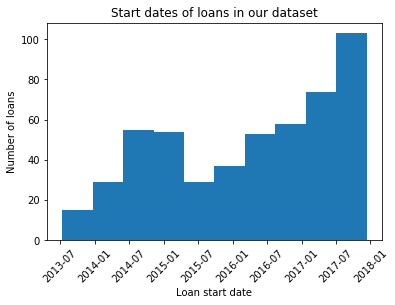

In [22]:
start_dates = labels.drop_duplicates('loan_id')['date_of_first_payment']
start_dates.hist(bins='auto', grid=False, xrot=45)
plt.title('Start dates of loans in our dataset')
plt.xlabel('Loan start date')
plt.ylabel('Number of loans');

First get a list of loans that will be used for training and validation. To make sure that validation covers unseen "future" dates, we sort loans by start date, and then split without shuffling.

In [23]:
train_loans, validation_loans = train_test_split(labels.drop_duplicates('loan_id').sort_values('date_of_first_payment')['loan_id'], test_size=VALIDATION_SIZE, shuffle=False)

Now we map them to our modeling dataframe:

In [24]:
train = df_modeling[df_modeling['loan_id'].isin(train_loans)].copy(deep=False)
validation = df_modeling[df_modeling['loan_id'].isin(validation_loans)].copy(deep=False)

We can see that the percentage of loans defaulting within 12 months decreases during our validation split. We could adjust our splits to take that into account (by stratifying - we would loose the temporal split strategy), but this can be a good way of testing our model's generalization to better or worse economic contexts:

In [25]:
print("12 month default rate:")
print(f"Train: {train['default_12mth'].mean():.2f}")
print(f"Validation: {validation['default_12mth'].mean():.2f}")

12 month default rate:
Train: 0.03
Validation: 0.03


In [26]:
for c in ['loan_missing_payment', 'second_account_holder', 'sex_primary_is_female', 'sex_secondary_is_female']:
    train[c] = train[c].map({True: 'Y', False: 'N'})
    validation[c] = validation[c].map({True: 'Y', False: 'N'})

# 3. Visualizations

## 3.1 Visualizing the defaulters timeline

In [27]:
labels_augmented = pd.merge(labels[['loan_id', 'default', 'date_of_default', 'date_of_first_payment', 'date_of_last_payment']].drop_duplicates(),
                            loan[['loan_id', 'loan_duration']])

In [28]:
min_date = pd.Period(datetime.datetime(2013, 1, 1), 'm')

get_month = lambda x: np.nan if pd.isnull(x) else x.n
labels_augmented['date_of_default_relative'] = (labels_augmented['date_of_default'].dt.to_period('m') - min_date).apply(get_month)
labels_augmented['date_of_first_payment_relative'] = (labels_augmented['date_of_first_payment'].dt.to_period('m') - min_date).apply(get_month)
labels_augmented['date_of_last_payment_relative'] = (labels_augmented['date_of_last_payment'].dt.to_period('m') - min_date).apply(get_month)

labels_augmented['exp_date_of_last_payment_relative'] = labels_augmented['date_of_first_payment_relative'] + labels_augmented['loan_duration']

labels_augmented.sort_values(['date_of_first_payment_relative', 'date_of_last_payment_relative'], inplace=True)

In [29]:
max_date_relative = labels_augmented['exp_date_of_last_payment_relative'].max()
max_date = min_date + max_date_relative # we can just add ints to time periods

defaulters = labels_augmented[labels_augmented['default']].copy(deep=False)
ticks = defaulters['loan_id']

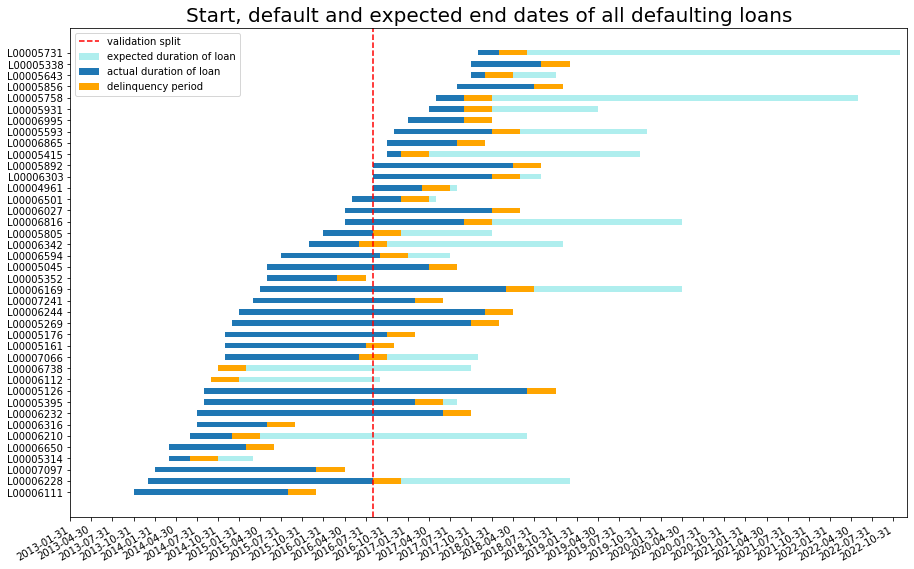

In [30]:
fig, ax = plt.subplots(figsize=(15,10))

ax.barh(ticks, defaulters['exp_date_of_last_payment_relative'] - defaulters['date_of_first_payment_relative'],
         left=defaulters['date_of_first_payment_relative'], height=0.5, color='paleturquoise', label='expected duration of loan')

ax.barh(ticks, defaulters['date_of_last_payment_relative'] - defaulters['date_of_first_payment_relative'],
         left=defaulters['date_of_first_payment_relative'], height=0.5, label='actual duration of loan')

ax.barh(ticks, 4,
         left=defaulters['date_of_last_payment_relative'], height=0.5, label='delinquency period', color='orange')

ax.axvline(x=(validation['prediction_date'].min().to_period('M') - min_date).n, color='red', linestyle='--', label='validation split')

ax.set_yticks(list(range(len(defaulters))))
ax.set_yticklabels(defaulters['loan_id']);

ax.set_xlim((0, max_date_relative))
ax.set_xticks(range(0, max_date_relative)[::3])
ax.set_xticklabels(pd.date_range(min_date.to_timestamp(), max_date.to_timestamp(), freq='m').date[::3])
fig.autofmt_xdate()

ax.legend()
ax.set_title('Start, default and expected end dates of all defaulting loans', fontdict={'fontsize': 20});

## 3.2 How do the features built impact default?

**Defaulters tend to have a more volatile account balance:**

We can see that the left chart has outliers, which are accounts with a highly volatile balance but that don't default within 12 months. These accounts might be future defaulters that our model can predict as risky even earlier than 12 months in advance.

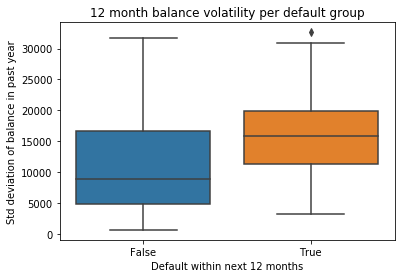

In [31]:
sns.boxplot(x='default_12mth', y='balance_std_current_year', data=train);
plt.title('12 month balance volatility per default group');
plt.xlabel('Default within next 12 months')
plt.ylabel('Std deviation of balance in past year');

**Default tends to happen when the remaining principal is low:**

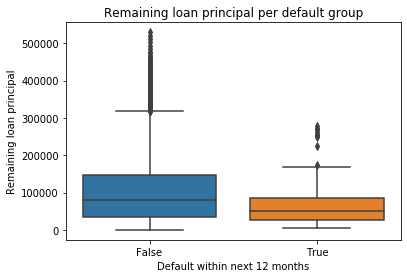

In [32]:
sns.boxplot(x='default_12mth', y='loan_remaining_principal', data=train)
plt.title('Remaining loan principal per default group');
plt.xlabel('Default within next 12 months')
plt.ylabel('Remaining loan principal');

**Defaulters tend to have smaller credit transactions on average:**

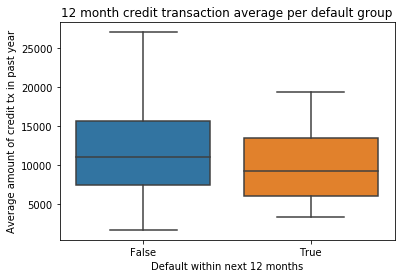

In [33]:
sns.boxplot(x='default_12mth', y='tx_credit_avg_amount', data=train)
plt.title('12 month credit transaction average per default group');
plt.xlabel('Default within next 12 months')
plt.ylabel('Average amount of credit tx in past year');

# 4. Save output for modeling

In [34]:
project.save_data('df_training.csv', train.to_csv(index=False), overwrite=True)
project.save_data('df_validation.csv', validation.to_csv(index=False), overwrite=True)

{'file_name': 'data_asset/df_validation.csv',
 'message': 'File saved to project storage.',
 'asset_id': '240cda00-7c08-4c6b-beeb-1908daad1ff0'}